#### Loading and preparing the PCam data for training deep learning models using tensorflow dataset (tfds)

Loading the required libraries

In [10]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"   # Delete if you have GPU's available
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Defining a function that splits images and labels and one-hot-encodes the labels

In [11]:
#vi bruger nedenstående med onehot encoding til CNN-delen
"""
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label
"""

"\ndef convert_sample(sample):\n    image, label = sample['image'], sample['label']  \n    image = tf.image.convert_image_dtype(image, tf.float32)\n    label = tf.one_hot(label, 2, dtype=tf.float32)\n    return image, label\n"

In [12]:
#convert_sample UDEN one-hot encoding
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image itself as the target label

Next we use the tensorflow dataset API - tfds - to load the data from you local directory. First you have to download the data manually from https://syddanskuni-my.sharepoint.com/:f:/g/personal/cmd_sam_sdu_dk/EiWD2LmuxCJBp-_tfGK7aL8Bdt2cPsb6MCpVs1pOYUcXAw?email=cmd%40sam.sdu.dk&e=2Vx6tL and store it on you local drive. First some important remarks:
- The folder structure is **crucial** and needs to be copied to your local drive. For example, if you with to use the folder denoted *c:\user\aml_take_home_exam* then you need to download the data to *c:\user\aml_take_home_exam\patch_camelyon\2.0.0*.
- As you can see from the example below this implies that my data is stored locally under *V:\BDADShareData2\DATA_TFDS_BDAD\patch_camelyon\2.0.0*
- By using tfds.load you do not need to load all data. If you only want 20% of the training data and 5% of test and validation data you simply specify **split=['train[:20%]','test[:5%]','validation[:5%]']**. In this case the variable ds1 contains only 20 percent of the training data while ds2 and ds3 contains 5% of the test and validation data respectively. This feature is important if you are facing hardware contraints.
- You can read more about tensorflow dataset here https://www.tensorflow.org/datasets 
- **Note** If you wish not to use data stored locally you can use download=True and tensorflow will download the data for you. 

In [13]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = r'C:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\Anvendtmaskinlæring\eksamen',
                        download=False,
                        shuffle_files=True)

Next we simple transform the data (by the function convert sample described previously) and getting ready for training by splitting it into batches.

In [14]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

The data is then ready to be applied for training, validation, testing etc...below just a very very simple illustration on how to construct and train a model based on the data we have prepared

In [28]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape


# Encoder
input_shape = (96, 96, 3)
latent_dim = 64

def build_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu')(x)
    return Model(inputs, encoded)

# Decoder
def build_decoder(latent_dim, input_shape):
    inputs = Input(shape=(latent_dim,))
    x = Dense(24 * 24 * 32, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Reshape((24, 24, 32))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) 
    return Model(inputs, decoded)

# Autoencoder
encoder = build_encoder(input_shape)
decoder = build_decoder(latent_dim, input_shape)
autoencoder = tf.keras.Sequential([encoder, decoder])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


# Print the summary of the autoencoder
autoencoder.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_25 (Functional)       (None, 64)                1200736   
                                                                 
 model_26 (Functional)       (None, 96, 96, 3)         1376163   
                                                                 
Total params: 2576899 (9.83 MB)
Trainable params: 2539139 (9.69 MB)
Non-trainable params: 37760 (147.50 KB)
_________________________________________________________________


Epoch 1/10
1639/1639 [==============================] - 443s 269ms/step - loss: 0.0358 - val_loss: 0.0366
Epoch 2/10
1639/1639 [==============================] - 442s 269ms/step - loss: 0.0339 - val_loss: 0.0366
Epoch 3/10
1639/1639 [==============================] - 449s 274ms/step - loss: 0.0337 - val_loss: 0.0362
Epoch 4/10
1639/1639 [==============================] - 431s 263ms/step - loss: 0.0337 - val_loss: 0.0362
Epoch 5/10
1639/1639 [==============================] - 407s 248ms/step - loss: 0.0335 - val_loss: 0.0359
Epoch 6/10
1639/1639 [==============================] - 401s 245ms/step - loss: 0.0333 - val_loss: 0.0359
Epoch 7/10
1639/1639 [==============================] - 409s 250ms/step - loss: 0.0333 - val_loss: 0.0358
Epoch 8/10
1639/1639 [==============================] - 414s 252ms/step - loss: 0.0332 - val_loss: 0.0356
Epoch 9/10
1639/1639 [==============================] - 412s 251ms/step - loss: 0.0330 - val_loss: 0.0356
Epoch 10/10
1639/1639 [=======================

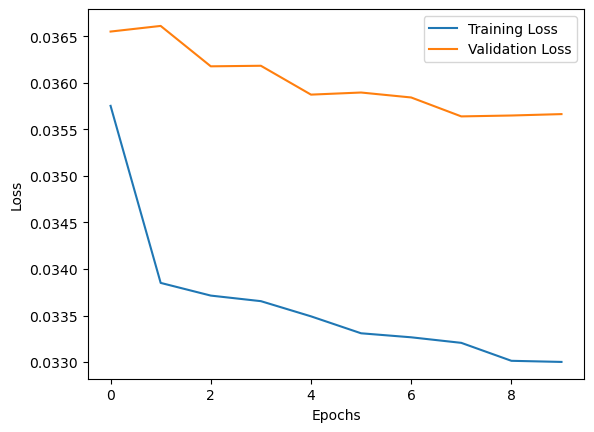

In [19]:
history = autoencoder.fit(train_dataset, validation_data=validation_dataset, epochs=10)

# Access the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training progress
import matplotlib.pyplot as plt

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 199ms/step


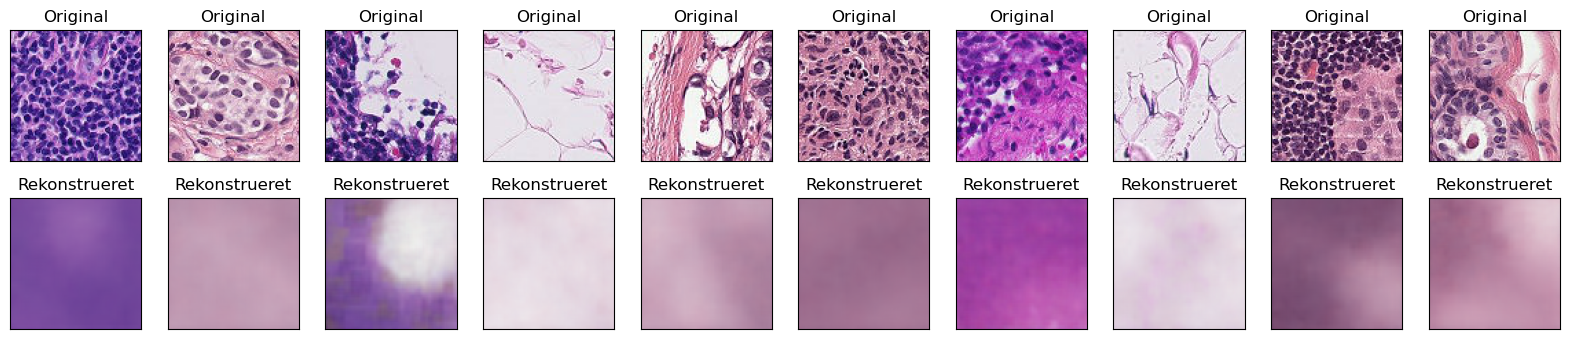

In [20]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Antal billeder at vise
n = 10

# Hent nogle eksempler fra testdatasættet
samples = next(iter(test_dataset))[0][:n]  # Brug kun inputbilleder

# Generer rekonstruerede billeder fra de originale billeder
reconstructed_images = autoencoder.predict(samples)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("Original")
    plt.imshow(tf.squeeze(samples[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display rekonstruktion
    bx = plt.subplot(2, n, i + 1 + n)
    plt.title("Rekonstrueret")
    plt.imshow(tf.squeeze(reconstructed_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

1/1 [==============================] - 0s 46ms/step


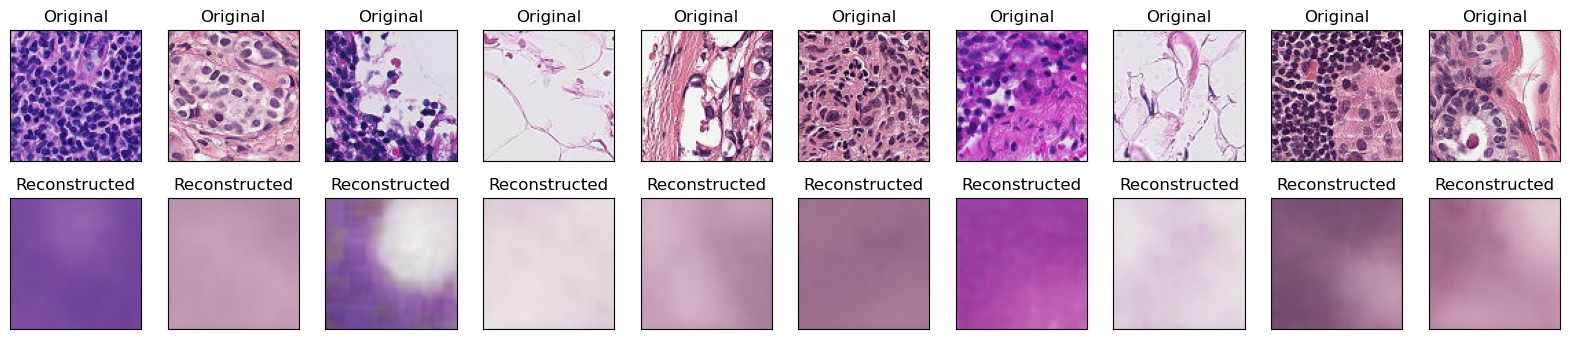

In [21]:


reconstructed_images = autoencoder.predict(samples)

plt.figure(figsize=(20, 4))
for i, (sample, reconstructed_image) in enumerate(zip(samples, reconstructed_images)):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("Original")
    plt.imshow(tf.squeeze(sample))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    bx = plt.subplot(2, n, i + 1 + n)
    plt.title("Reconstructed")
    plt.imshow(tf.squeeze(reconstructed_image))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()